In [131]:
import numpy as np
from filterpy.kalman import EnsembleKalmanFilter 
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import time

In [132]:
def f(t_n,X_n,σ, b, r): #X_n=(x_n,y_n,z_n)
    (x,y,z)=X_n
    
    f_1 = σ*(y-x)
    f_2 = x*(r-z)-y
    f_3 = x*y-b*z
    return np.array([f_1,f_2,f_3])

In [133]:
def RK4_Lorenz(γ,X0,N,T): #we have N+1 discretization points
    (σ,b,r)=γ
    
    dt=T/N
    
    X = np.zeros( (N+1, len(X0)) )
    T=np.zeros(N+1)
    X[0] = X0
    
    t=0. #=t_0
    for n in range(1,N+1):
        
        K1=f(t, X[n-1],σ,b,r)
        K2=f(t+dt/2., X[n-1] + 1./2. * K1 * dt,σ,b,r)
        K3=f(t+dt/2., X[n-1] + 1./2. * K2 * dt,σ,b,r)
        K4=f(t+dt, X[n-1]+ K3 * dt,σ,b,r)
        T[n]=t
        X[n]=X[n-1]+ dt/6.* (K1+2.*K2+2.*K3+K4)
        t+=dt
        
    return X[:,0],X[:,1],X[:,2],T

In [134]:
γ=(12.,6.,12.) #(σ,b,r)
X0=(-10.,-10.,25.) #(x0,y0,z0)
N=int(5/0.01)
T=5

In [135]:
lorenz1=RK4_Lorenz(γ,X0,N,T)

In [136]:
γ=(11.,6.,11.) #(σ,b,r)
X0=(-10.,-10.,25.) #(x0,y0,z0)
N=int(5/0.1)
T=5

In [137]:
lorenz2=RK4_Lorenz(γ,X0,N,T)

In [138]:
def plot_lorenz(num_figure,fct,γ,X0,N,T):
    x,y,z=fct(γ,X0,N,T)
    fig=plt.figure(figsize=(18,5))
    
    #plot 2D x en fonction de y
    ax0 = fig.add_subplot(1,3,1)
    ax0.set_title(str(fct.__name__)+'\n'+num_figure+'\n')
    ax0.plot(x,y)
    
    ax0.set_xlabel("x")
    ax0.set_ylabel("y")
    
    #plot 2D x en fonction de z
    ax1 = fig.add_subplot(1,3,2)
    ax1.set_title(fr"$\sigma={γ[0]}, b={γ[1]}, r={γ[2]},$" +'\n'+ fr"$X0=({X0[0]}, {X0[1]}, {X0[2]}), N={N}, T={T}$"+'\n')
    ax1.plot(x,z)
    
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")
    
    #plot 3D
    ax3 = fig.add_subplot(1,3,3, projection='3d')
    ax3.plot(x,y,z)
    ax3.plot(X0[0],X0[1],X0[2],"r.")
    
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_zlabel("z")
    ax3.view_init(28,-95)
    return x,y,z

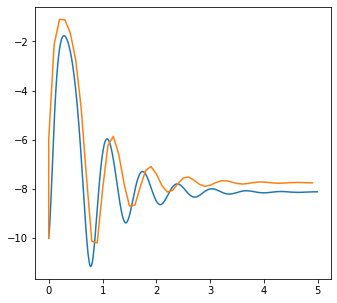

In [139]:
fig=plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,2)
ax1.plot(lorenz1[3],lorenz1[0])
ax1.plot(lorenz2[3],lorenz2[0])

In [143]:
def hx(x):
   return x


def fx(x, dt,σ,b,r):
    def f(t_n,X_n,σ, b, r): #X_n=(x_n,y_n,z_n)
        (x,y,z)=X_n
    
        f_1 = σ*(y-x)
        f_2 = x*(r-z)-y
        f_3 = x*y-b*z
        return np.array([f_1,f_2,f_3])
    K1=f(t, x,σ,b,r)
    K2=f(t+dt/2., x + 1./2. * K1 * dt,σ,b,r)
    K3=f(t+dt/2., x + 1./2. * K2 * dt,σ,b,r)
    K4=f(t+dt, x+ K3 * dt,σ,b,r)
    X_next=x+ dt/6.* (K1+2.*K2+2.*K3+K4)
    return X_next

γ=(11.,6.,10.) #(σ,b,r)
N=10
T=5

x = np.array([-10.,-10.,25.])#(x0,y0,z0)
P = np.eye(3) * 2.
dt= N*0.01
f = EnsembleKalmanFilter (x=x, P=P, dim_z=3, dt=dt, N=8,
         hx=hx, fx=lambda x,dt:fx(x,dt,11.,6.,11.))

std_noise = np.eye(3)*0.001 
f.R *= std_noise # matrice de cov associer a la mesure
f.Q = Q_discrete_white_noise(3, dt, .01) #bruit blanc centree en 0

def read_sensor(index):
    return np.array([lorenz1[0][index],lorenz1[1][index],lorenz1[2][index]])
t=dt  
index=N
tab_etat=[]
tab_temps=[]
while (t<T):
    z = read_sensor(index)
    f.predict()
    f.update(z)
    tab_etat.append(f.x[0])
    tab_temps.append(t)
    index+=N                 
    t=t+dt
print(tab_etat)

[-5.821065061731793, -2.4298211966501264, -1.6125055498990353, -2.0144896365552167, -3.234347403816121, -5.541690626151436, -8.74325993769927, -10.380884632103687, -8.858262325716588, -6.5928243893971095, -5.803434024562643, -6.250211194509312, -7.442515575918884, -8.458592977349767, -8.41863976492276, -7.620094198515472, -6.785746431921357, -6.549361062726566, -6.863207092893042, -7.3412836876106695, -7.652359524582112, -7.431049296642938, -7.166415899961688, -7.202146551646347, -7.324992587254126, -7.634674752197199, -7.824968118207782, -7.467939548291819, -7.2426610895301335, -7.169288859288042, -7.295867248135927, -7.395682946081807, -7.3603770429945685, -7.285086658216839, -7.275713593279712, -7.2407223154048905, -7.30436194677589, -7.399070628063472, -7.3840406595644605, -7.344923178778893, -7.332712677342433, -7.437334550768322, -7.292852852201841, -7.388138738954164, -7.341568520491964, -7.344356567668567, -7.540670823095758, -7.4705178194404365, -7.626202051203736, -7.79715626

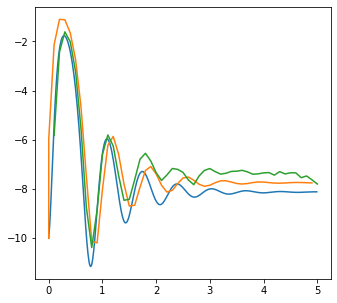

In [148]:
fig=plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,2)
ax1.plot(lorenz1[3],lorenz1[0])
ax1.plot(lorenz2[3],lorenz2[0])
ax1.plot(tab_temps,tab_etat)
